In [3]:
!Cabocha -f1 data/neko.txt > work/neko.txt.cabocha

# 40. 係り受け解析結果の読み込み（形態素）

In [3]:
class Morph:
    def __init__(self, parse_result):
        morph = self._txt2morph(parse_result)
        self.surface = morph['surface']
        self.base = morph['base'] 
        self.pos = morph['pos'] 
        self.pos1 = morph['pos1']

    def _txt2morph(self, parse_result):
        splited_parse_result = parse_result.split('\t')
        splited_parse_result[1] = splited_parse_result[1].split(',')
        return {
            'surface':splited_parse_result[0],
            'base':splited_parse_result[1][6],
            'pos':splited_parse_result[1][0],
            'pos1':splited_parse_result[1][1]
        }
    
    def get_members_string(self):
        return f'surface : {self.surface}, base : {self.base}, pos : {self.pos}, pos1 : {self.pos1}'


sentence_list = list() 
with open('./work/neko.txt.cabocha', mode = 'r') as f:
    sentence = list() 
    for line in f:
        line = line.rstrip()
        if line == 'EOS':
            if sentence: sentence_list.append(sentence)
            sentence = list()
            continue
        if line[0] == '*' and line[1] == ' ': continue
        sentence.append(Morph(line))

In [4]:
for morph in sentence_list[2]:
    print(morph.get_members_string())

surface : 名前, base : 名前, pos : 名詞, pos1 : 一般
surface : は, base : は, pos : 助詞, pos1 : 係助詞
surface : まだ, base : まだ, pos : 副詞, pos1 : 助詞類接続
surface : 無い, base : 無い, pos : 形容詞, pos1 : 自立
surface : 。, base : 。, pos : 記号, pos1 : 句点


# 41. 係り受け解析結果の読み込み（文節・係り受け）

In [32]:
from operator import itemgetter
from functools import reduce

In [100]:
'''
Class Chunk
文節のクラス
---Member---
morphs: 形態素のリスト 
dst: 係り先文節インデックス番号
srcs: 係り元文節インデックス番号のリスト
'''
class Chunk(Morph):
    def __init__(self):
        self.morphs = list()
        self.dst = -1
        self.srcs = list()
    
    def append_morph(self, parse_result):
        self.morphs.append(Morph(parse_result))
        
    def append_srcs(self, src):
        self.srcs.append(src)
    
    def set_dst(self, dst):
        self.dst = dst
    
    def get_members_string(self):
        morphs = reduce(lambda a, b: a + '(' + b.get_members_string() + ')\n', self.morphs, '')
        return f'morphs : {morphs}, dst : {self.dst}, srcs : {self.srcs}'

    def morphs2string(self):
        return reduce(lambda a, b: a + (b.surface if b.pos != '記号' else ''), self.morphs, '')
    
    def check_pos(self, pos):
        for morph in self.morphs:
            if morph.pos == pos: return True
        return False

In [101]:
sentence_list = list() #そのうちiterに変える
with open('./work/neko.txt.cabocha', mode = 'r') as f:
    chunk_dict = dict()
    for line in f:
        line = line.rstrip()
        if line == 'EOS':
            sentence = [x[1] for x in sorted(chunk_dict.items(), key = itemgetter(0))]
            if sentence: sentence_list.append(sentence)
            chunk_dict = dict()
            continue
        if line[0] == '*' and line[1] == ' ':
            splited_line = line.split()
            idx = int(splited_line[1])
            src = int(splited_line[2][:-1])
            if not idx in chunk_dict: chunk_dict[idx] = Chunk()
            if idx != -1: chunk_dict[idx].set_dst(src)
            if src != -1 and not src in chunk_dict: chunk_dict[src] = Chunk()
            if src != -1: chunk_dict[src].append_srcs(idx)
        else:
            chunk_dict[idx].append_morph(line)

In [102]:
for chunk in sentence_list[7]:
    print(chunk.get_members_string())

morphs : (surface : この, base : この, pos : 連体詞, pos1 : *)
, dst : 1, srcs : []
morphs : (surface : 書生, base : 書生, pos : 名詞, pos1 : 一般)
(surface : という, base : という, pos : 助詞, pos1 : 格助詞)
(surface : の, base : の, pos : 名詞, pos1 : 非自立)
(surface : は, base : は, pos : 助詞, pos1 : 係助詞)
, dst : 7, srcs : [0]
morphs : (surface : 時々, base : 時々, pos : 副詞, pos1 : 一般)
, dst : 4, srcs : []
morphs : (surface : 我々, base : 我々, pos : 名詞, pos1 : 代名詞)
(surface : を, base : を, pos : 助詞, pos1 : 格助詞)
, dst : 4, srcs : []
morphs : (surface : 捕え, base : 捕える, pos : 動詞, pos1 : 自立)
(surface : て, base : て, pos : 助詞, pos1 : 接続助詞)
, dst : 5, srcs : [2, 3]
morphs : (surface : 煮, base : 煮る, pos : 動詞, pos1 : 自立)
(surface : て, base : て, pos : 助詞, pos1 : 接続助詞)
, dst : 6, srcs : [4]
morphs : (surface : 食う, base : 食う, pos : 動詞, pos1 : 自立)
(surface : という, base : という, pos : 助詞, pos1 : 格助詞)
, dst : 7, srcs : [5]
morphs : (surface : 話, base : 話, pos : 名詞, pos1 : サ変接続)
(surface : で, base : だ, pos : 助動詞, pos1 : *)
(surface : ある, base 

# 42. 係り元と係り先の文節の表示

In [103]:
for chunk in sentence_list[7]:
    if chunk.dst != -1: print(f'{chunk.morphs2string()}\t{sentence_list[7][chunk.dst].morphs2string()}')

この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である


# 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [107]:
noun_to_verb = list()
for sentence in sentence_list:
    for chunk in sentence:
        if chunk.dst == -1: continue
        if chunk.check_pos('名詞') and sentence[chunk.dst].check_pos('動詞'):
            noun_to_verb.append((chunk.morphs2string(), sentence[chunk.dst].morphs2string()))

In [108]:
for idx in range(5):
    print(noun_to_verb[idx])

('どこで', '生れたか')
('見当が', 'つかぬ')
('所で', '泣いて')
('ニャーニャー', '泣いて')
('いた事だけは', '記憶している')


# 44. 係り受け木の可視化

In [121]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display

In [112]:
graph = pydot.Dot(graph_type = 'digraph')
for idx, chunk in enumerate(sentence_list[7]):
    if chunk.dst == -1: continue
    id1 = idx
    id2 = chunk.dst
    label1 = chunk.morphs2string()
    label2 = sentence_list[7][id2].morphs2string()
    graph.add_node(pydot.Node(id1, label=label1))
    graph.add_node(pydot.Node(id2, label=label2))
    graph.add_edge(pydot.Edge(id1, id2))

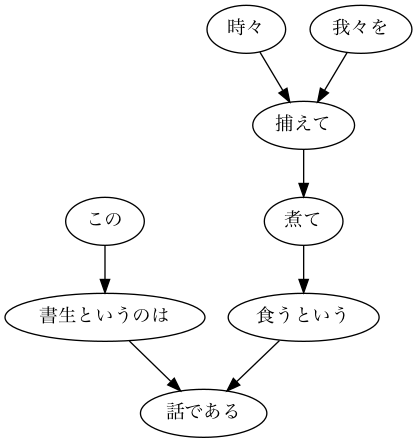

In [122]:
plt = Image(graph.create_png())
display(plt)
#graph.write_png('./work/result.png')

# 45. 動詞の格パターンの抽出

# 46. 動詞の格フレーム情報の抽出

# 47. 機能動詞構文のマイニング

# 48. 名詞から根へのパスの抽出

# 49. 名詞間の係り受けパスの抽出